In [ ]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# https://drive.google.com/file/d/1Dr7OA-780-HGJNhflop4yzdw32v6yqMR/view?usp=sharing
id = "1Dr7OA-780-HGJNhflop4yzdw32v6yqMR"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('fraud-oracle.csv')


In [ ]:
 pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 710 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.binary import BinaryEncoder
from category_encoders.one_hot import OneHotEncoder

# Part 1: EDA

## data shape and types

In [ ]:
df = pd.read_csv('fraud-oracle.csv')
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [ ]:
print(df.shape)

(15420, 33)


### 1.1 Numerical features

In [ ]:
cols = df.columns
for col in cols:
    if df[col].dtypes == 'int':
        print(col)

WeekOfMonth
WeekOfMonthClaimed
Age
FraudFound_P
PolicyNumber
RepNumber
Deductible
DriverRating
Year


## Do we need this? ? The Pairplot indicate non-correlation between all the numberic features. 


In [ ]:
# def correlation_heatmap(data):
#     correlations = data.corr()

#     fig, ax = plt.subplots(figsize=(10,10))
#     sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
#                 square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
#     plt.show();
    
# correlation_heatmap(df)

#sns.pairplot(data=df, diag_kind='kde')

### PolicyNumber

In [ ]:
# this column will be dropped, arbitrary number which adds no value to prediction 
df['PolicyNumber']

0            1
1            2
2            3
3            4
4            5
         ...  
15415    15416
15416    15417
15417    15418
15418    15419
15419    15420
Name: PolicyNumber, Length: 15420, dtype: int64

### RepNumber????? what this column mean?

In [ ]:
sorted(df['RepNumber'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

### 1.2 Categorical features

In [ ]:
cols = df.columns
for col in cols:
    if df[col].dtypes == 'object':
        print(col)

Month
DayOfWeek
Make
AccidentArea
DayOfWeekClaimed
MonthClaimed
Sex
MaritalStatus
Fault
PolicyType
VehicleCategory
VehiclePrice
Days_Policy_Accident
Days_Policy_Claim
PastNumberOfClaims
AgeOfVehicle
AgeOfPolicyHolder
PoliceReportFiled
WitnessPresent
AgentType
NumberOfSuppliments
AddressChange_Claim
NumberOfCars
BasePolicy


# Part 3 Data Pre-processing

## Missing Value

In [ ]:
print('DayOfWeekClaimed',df['DayOfWeekClaimed'].unique())
print('MonthClaimed',df['MonthClaimed'].unique())

DayOfWeekClaimed ['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday'
 '0']
MonthClaimed ['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct'
 '0']


In [ ]:
print(df.loc[(df['DayOfWeekClaimed']=='0')])
print(df.loc[(df['MonthClaimed']=='0')])

     Month  WeekOfMonth DayOfWeek   Make AccidentArea DayOfWeekClaimed  \
1516   Jul            2    Monday  Honda        Rural                0   

     MonthClaimed  WeekOfMonthClaimed   Sex MaritalStatus  ...  AgeOfVehicle  \
1516            0                   1  Male        Single  ...           new   

     AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
1516          16 to 17                No             No  External   

      NumberOfSuppliments  AddressChange_Claim  NumberOfCars  Year  BasePolicy  
1516                 none            no change     1 vehicle  1994  All Perils  

[1 rows x 33 columns]
     Month  WeekOfMonth DayOfWeek   Make AccidentArea DayOfWeekClaimed  \
1516   Jul            2    Monday  Honda        Rural                0   

     MonthClaimed  WeekOfMonthClaimed   Sex MaritalStatus  ...  AgeOfVehicle  \
1516            0                   1  Male        Single  ...           new   

     AgeOfPolicyHolder PoliceReportFiled WitnessPresent 

## drop the row which has the missing values

In [ ]:
df2 = df.loc[df['DayOfWeekClaimed']!='0']
df2.reset_index(drop=True, inplace=True)
len(df2)

15419

In [ ]:
#There are 319 rows where the feature Age is assigned a zero, 
print(len(df2[df2['Age']==0]))

print(len(df2[df2['AgeOfPolicyHolder']=='16 to 17']))

#confirms that every row with Age=0, has a Policy Holder that is aged between 16 and 17 years.
print(df2.loc[(df2['Age']==0),'AgeOfPolicyHolder'].unique())

#though for the displayed rows the policy holder is said to be between 16 and 17 years old. 
df2.loc[df2['Age']==0, 'AgeOfPolicyHolder']

319
319
['16 to 17']


7        16 to 17
13       16 to 17
28       16 to 17
31       16 to 17
58       16 to 17
           ...   
15242    16 to 17
15261    16 to 17
15273    16 to 17
15378    16 to 17
15391    16 to 17
Name: AgeOfPolicyHolder, Length: 319, dtype: object

In [ ]:
#Need to check the policy holders age and then reassign a value.
df2_age0_idx = (df2['Age']==0)

In [ ]:
df2.loc[list(df2_age0_idx),'Age']=16.5
#Confirms that there are no Ages equal to 0.
print(df2['Age'].unique()==0)
len(df2[df2['Age']==0])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


0

## Binary Encoding 

In [ ]:
from sklearn.preprocessing import LabelEncoder

cols = ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']
print('AccidentArea',df['AccidentArea'].unique())
print('Sex',df['Sex'].unique())
print('Fault',df['Fault'].unique())
print('PoliceReportFiled',df['PoliceReportFiled'].unique())
print('WitnessPresent',df['WitnessPresent'].unique())
print('AgentType',df['AgentType'].unique())
discrete_columns = []

for col in cols:
    if df2[col].dtypes == 'object':
        discrete_columns.append(col)

for col in discrete_columns:
    enc = LabelEncoder()
    values = df2[col].unique()
    enc_fit = enc.fit(values)
    df2[col] = enc_fit.transform(df2[col])

AccidentArea ['Urban' 'Rural']
Sex ['Female' 'Male']
Fault ['Policy Holder' 'Third Party']
PoliceReportFiled ['No' 'Yes']
WitnessPresent ['No' 'Yes']
AgentType ['External' 'Internal']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
to_drop = ['PolicyNumber','FraudFound_P']
X = df2.drop(to_drop, axis=1).copy()
y=df2['FraudFound_P'].copy()

## One Hot Encoding 

In [ ]:
X.shape
columns = ['Make','MaritalStatus','PolicyType','VehicleCategory','BasePolicy']
for col in columns:
    print(col,len(df[col].unique()))

Make 19
MaritalStatus 4
PolicyType 9
VehicleCategory 3
BasePolicy 3


In [ ]:
from sklearn.preprocessing import OneHotEncoder

def OneHotEncoding(df, enc, categories):  
    transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names_out(categories))
    return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)


for col in ['Make','MaritalStatus','PolicyType','VehicleCategory','BasePolicy']:
    categories = [col]
    enc_ohe = OneHotEncoder()
    enc_ohe.fit(X[categories])
    X = OneHotEncoding(X, enc_ohe, categories)

In [ ]:
print(X.shape)

(15419, 64)


## Ordinal Encoding 

In [ ]:
col_ordering = [
    {'col':'Month','mapping':{'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}},
    {'col':'DayOfWeek','mapping':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}},
    {'col':'DayOfWeekClaimed','mapping':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}},
    {'col':'MonthClaimed','mapping':{'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}},
    {'col':'PastNumberOfClaims','mapping':{'none':0 ,'1':1,'2 to 4':2,'more than 4':5 }},
    {'col':'NumberOfSuppliments','mapping':{'none':0,'1 to 2':1,'3 to 5':3,'more than 5':6}}, 
    {'col':'VehiclePrice','mapping':{'more than 69000':69001,'20000 to 29000':24500,'30000 to 39000':34500,'less than 20000':19999,'40000 to 59000':49500,'60000 to 69000':64500}},
    {'col':'AgeOfVehicle','mapping':{'3 years':3,'6 years':6,'7 years':7,'more than 7':8,'5 years':5,'new':0,'4 years':4,'2 years':2}},
]
ord_encoder = OrdinalEncoder(mapping = col_ordering, return_df=True)

In [ ]:
X2 = ord_encoder.fit_transform(X)

In [ ]:
col_map = [{'Days_Policy_Accident':{'more than 30':31,'15 to 30':22.5,'none':0,'1 to 7':4,'8 to 15':11.5}},
    {'Days_Policy_Claim':{'more than 30':31,'15 to 30':22.5,'8 to 15':11.5,'none':0}},
    {'AgeOfPolicyHolder':{'26 to 30':28,'31 to 35':33,'41 to 50':45.5,'51 to 65':58,'21 to 25':23,'36 to 40':38,'16 to 17':16.5,
                                          'over 65':66,'18 to 20':19}},
    {'AddressChange_Claim':{'1 year':1,'no change':0,'4 to 8 years':6,'2 to 3 years':2.5,'under 6 months':0.5}},
    {'NumberOfCars':{'3 to 4':3.5,'1 vehicle':1,'2 vehicles':2,'5 to 8':6.5,'more than 8':9}},
]

X3 = X2.copy()
for i in range(len(col_map)):
    X3.replace(col_map[i], inplace=True)

In [ ]:
X3.shape

(15419, 64)

## Training and Testing Data Split

In [ ]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X3, y, test_size=0.25, stratify = y, random_state=10) #stratified sampling

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 11564 observation with 64 features
test data has 3855 observation with 64 features


## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE 
unique, counts = np.unique(y_train, return_counts=True)
y_train_category_count_dic = {k:v for k,v in zip(unique,counts) }
y_train_category_count_dic

{0: 10872, 1: 692}

In [ ]:
# Saving the original values before oversampling for future use.
X_train_og, y_train_og = X_train, y_train

In [ ]:
sm = SMOTE(random_state=5,sampling_strategy=1)
X_train, y_train = sm.fit_resample(X_train,y_train)
unique, counts = np.unique(y_train, return_counts=True)
new_count = {k:v for k,v in zip(unique,counts) }
new_count


{0: 10872, 1: 10872}

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = X3.columns[(X3.dtypes == 'float64') | (X3.dtypes == 'int64')]
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
X_train.shape

(21744, 64)

# Models

## Visualization Code:

In [ ]:
# Select the dataframe to run the visuals on here:
# Right now the df variable is the raw data before pre-processing:
# df = ...

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.mplot3d import axes3d
from matplotlib import style

#!!pip install plotly.express # Not sure if colab has this pre-installed so may need to run this pip install first
import plotly.express as px

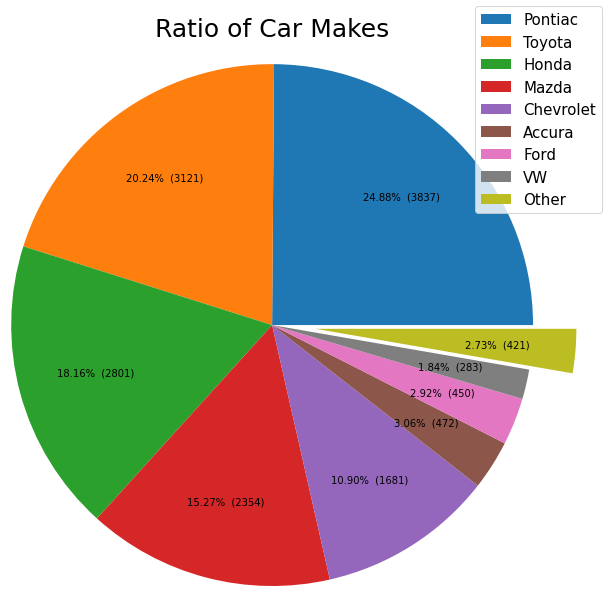

'\nPontiac, Toyota, Honda, Mazda, and Chevrolet make up the majority of car makes in the dataset.\n'

In [ ]:
# Displaying pie chart of distribution of accidents by car make.

car_dict = df['Make'].value_counts()
grouped = {}
threshold = 200  # Limit of number of makes of a car before labeling it as 'Other'
# every make with fewer than 200 cars here

# Function to get labels within the pie chart.
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Grouping the car makes with fewer than "Threshold" number of makes into an "Other" category.
for key, item in car_dict.items():
    if item < threshold:
        key = 'Other'
    grouped[key] = grouped.get(key, 0) + item

plt.title("Ratio of Car Makes", fontdict={"fontsize":25}, y=1.8)
# Setting up the pie chart as needed and popping out the "Other" category.
plt.pie(x=grouped.values(), labels=grouped.keys(), radius=3,
        explode=[0]*(len(grouped)-1) + [0.5], # Setting up array for popping out other category.
        autopct=make_autopct(grouped.values()), pctdistance=0.7,
        labeldistance=None)
plt.legend(loc="upper left", bbox_to_anchor=[1.4,2], fontsize=15)
plt.show()
'''
Pontiac, Toyota, Honda, Mazda, and Chevrolet make up the majority of car makes in the dataset.
'''

In [ ]:
# Pie chart that shows imbalance in dataset in both gender and fraud count.
fig = px.sunburst(df, path=['FraudFound_P', 'Sex'])
fig.update_traces(labels=["Female", "Female", "Male", "Male", "Non-Fraudulent", "Fraudulent"],
                  texttemplate="%{label}: %{value} <br>(%{percentParent:.2%})",
                  insidetextorientation="horizontal")
fig.update_layout(title={"text": "<b>Visualization of Dataset Imbalance</b>", "x": 0.5},width=750, height=750)
fig.show()

In [ ]:
# Histogram showing distribution of age by gender
fig = px.histogram(df, x="Age", color="Sex")
fig.update_layout(title={"text": "<b>Distribution of Age by Gender</b>", "x": 0.5})
fig.show()

In [ ]:
# Going to add another chart here comparing different car makes by age of the cars
# Probably a heatmap?
# Similar to the ones here: https://www.kaggle.com/code/brcsnt/fraud-data-analysis-with-plotly
# Let me know if you have anything specific in mind for this chart or any other comparisons you want to see as a comment in the cell below.
order_array = [['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7'], 
               ['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000']]

fig = px.density_heatmap(df, x='Make', y='VehiclePrice', # Currently have ordered array for AgeOfVehicle and VehiclePrice
                         #facet_col='Sex', # Can also add facet_row to add more heatmaps, and use other columns for facets like marital status
                         marginal_x='histogram', # Can be violin, rug, box, or histogram and can also have one for y axis, if using facet_col, can only use marginal x...
                         text_auto=True) # Decide whether values should be shown on the heatmap.
fig.update_yaxes(categoryorder='array', categoryarray=order_array[1]) # Order of y-axis, change 0 to 1 if using vehicle price instead of age.
#fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) # Cleans up title for facet headings.
fig.show()

In [ ]:
# Suggestions for more visuals here: 
# 

## Build Models

> 



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import numpy

## Baseline model (New Add)


In [ ]:
#Dummy Classifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
clf_base = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
y_base_pred = clf_base.predict(X_test)

#Distribution of y test
print('y actual : \n' +  str(y_test.value_counts()))

#Distribution of y predicted
print('y predicted : \n' + str(pd.Series(y_base_pred).value_counts()))

y actual : 
0    3624
1     231
Name: FraudFound_P, dtype: int64
y predicted : 
0    3855
dtype: int64


In [ ]:
# Model Evaluation metrics 
print(classification_report(y_test, y_base_pred))

#Dummy Classifier Confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_base_pred)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3624
           1       0.00      0.00      0.00       231

    accuracy                           0.94      3855
   macro avg       0.47      0.50      0.48      3855
weighted avg       0.88      0.94      0.91      3855

Confusion Matrix : 
[[3624    0]
 [ 231    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Logistic Regression 

In [ ]:
# Logistic Regression
classifier_logistic = LogisticRegression()
classifier_logistic.fit(X_train, y_train)  # train the model 

accuracy_score_logistic = classifier_logistic.score(X_test, y_test)

y_pred = classifier_logistic.predict(X_test)


print(classification_report(y_test, y_pred))

# print('Accuracy_Score:', accuracy_score_logistic)
# print('Recall:', tp/(fn+tp))
# print('Precision:', tp/(fp+tp))
# print('f1 score',f1_score(y_test, y_pred))
# np.unique(y_pred)



              precision    recall  f1-score   support

           0       0.97      0.73      0.83      3624
           1       0.13      0.62      0.21       231

    accuracy                           0.72      3855
   macro avg       0.55      0.68      0.52      3855
weighted avg       0.92      0.72      0.80      3855



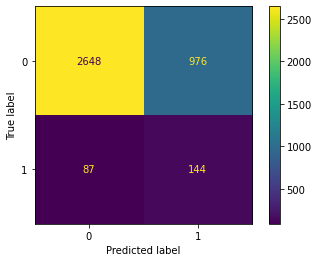

In [ ]:
# Logistic Regression Classifier Confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))
cm = confusion_matrix(y_test,y_pred,labels= classifier_logistic.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier_logistic.classes_)
disp.plot()


              precision    recall  f1-score   support

           0       0.97      0.72      0.83      3624
           1       0.13      0.64      0.21       231

    accuracy                           0.72      3855
   macro avg       0.55      0.68      0.52      3855
weighted avg       0.92      0.72      0.79      3855



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

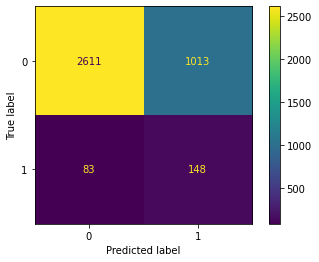

In [ ]:
#Grid Search
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')
grid_clf_acc.fit(X_train, y_train)

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(X_test)

# New Model Evaluation metrics 
print(classification_report(y_test, y_pred_acc))  

#Logistic Regression (Grid Search) Confusion matrix
# confusion_matrix(y_test,y_pred_acc)
cm_grid = confusion_matrix(y_test,y_pred_acc,labels= grid_clf_acc.classes_)
disp_grid = ConfusionMatrixDisplay(confusion_matrix=cm_grid,display_labels=grid_clf_acc.classes_)
disp_grid.plot()

## KNN

In [ ]:
# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier(n_neighbors=7)

classifier_KNN.fit(X_train, y_train)

classifier_KNN.score(X_test,y_test)

y_pred = classifier_KNN.predict(X_test)

accuracy_score_KNN = classifier_KNN.score(X_test, y_test)
print(classification_report(y_test, y_pred))  

#dtc_train_acc = accuracy_score(y_train, )
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Accuracy_Score:', accuracy_score_KNN)
print('f1 score',f1_score(y_test, y_pred))
print('Recall:', tp/(fn+tp))
print('Precision:', tp/(fp+tp))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      3624
           1       0.13      0.48      0.20       231

    accuracy                           0.77      3855
   macro avg       0.54      0.63      0.53      3855
weighted avg       0.91      0.77      0.82      3855

Accuracy_Score: 0.7660181582360571
f1 score 0.19893428063943164
Recall: 0.48484848484848486
Precision: 0.12513966480446928


In [ ]:
# Possible hyperparamter options for KNN
# Choose k
from sklearn.model_selection import GridSearchCV
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

parameters = {
    'n_neighbors':[1,3,5,7,9]
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9]})

## DNN

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras

from tensorflow.python.data import Dataset
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, RepeatedEditedNearestNeighbours

keras.utils.set_random_seed(42) # setting random state for the run


In [ ]:
# One-hot encoding the target variable
# The model was only predicting non-fraud claims (All 0's) before this.
# It just creates a true and false column instead of having it in one column.
y_train_e = pd.get_dummies(y_train, drop_first=False)
y_test_e = pd.get_dummies(y_test, drop_first=False)

#y_train_s = y_train_s.to_frame() # Converting targets to dataframe from series instead of encoding.  
#Need to work on confusion matrix function to get this method working.

In [ ]:
# Building the base model.
# It has 2 hidden layer using relu activation function
# The last layer is for the output
# Using sigmoid activation function for the output since thats the one used for binary classification
# Loss function after the comment is the possible one to use if using no activation function for the output layer
# Can also use other optimizer functions but adam seems to do best of the two I tested
# Can add more metrics to check how the model does if needed but just using these 4 for now.

NEU = 64 # Number of neurons, typically same as number of classes/features

def build_model(inner_act=tf.nn.relu, outer_act=tf.nn.sigmoid, loss='binary_crossentropy', 
                optimizer='adam', reg1=None, reg2=None):
    model = keras.Sequential([
        keras.layers.Dense(NEU, activation=inner_act,
                           kernel_regularizer=reg1,
                           input_shape=(X_train.shape[1],),
                           name="DenseLayer1"),
        keras.layers.Dropout(0.35, name="DropoutLayer1"),
        keras.layers.Dense(NEU, activation=inner_act,
                           kernel_regularizer=reg2,
                           name="DenseLayer2"),
        keras.layers.Dropout(0.35, name="DropoutLayer2"),
        keras.layers.Dense(2, activation=outer_act,
                           name="OutputLayer")
      ])

    model.compile(loss= loss, # keras.losses.BinaryCrossentropy(from_logits=True),
                    optimizer=optimizer,
                    metrics=['mae', 
                             keras.metrics.BinaryAccuracy(name='accuracy'),
                             keras.metrics.Precision(name='precision'),
                             keras.metrics.Recall(name='recall')])
    
    return model

# Regularizers, change .l1 to .l2 depending on whether to use L1 or L2 regularizaiton
# the number in the parenthesis is learning rate, should be less than 1
# change None or remove from function call to stop using regularization 
reg1 = keras.regularizers.l2(0.005)
reg2 = keras.regularizers.l2(0.0005)

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

dnn_model = build_model(optimizer=opt, reg1=reg1, reg2=reg2)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DenseLayer1 (Dense)         (None, 64)                4160      
                                                                 
 DropoutLayer1 (Dropout)     (None, 64)                0         
                                                                 
 DenseLayer2 (Dense)         (None, 64)                4160      
                                                                 
 DropoutLayer2 (Dropout)     (None, 64)                0         
                                                                 
 OutputLayer (Dense)         (None, 2)                 130       
                                                                 
Total params: 8,450
Trainable params: 8,450
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# This is just the function to decide what the output looks like as the model is running through the epochs

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('|', end='')
    print('.', end='')

In [ ]:
counts = y_train_og.value_counts()
weight_for_0 = 0.2 #1/counts[0]
weight_for_1 = 0.8 #1/counts[1]
print(weight_for_0, weight_for_1) # Lower weights for 0 to increase importance of positive class
# Going to need to do some adjustment to this if we want to use class weights 
# Using the weights after the comments end up making the model predict all 1's

0.2 0.8


In [ ]:
# Takes about 2 minutes to run through google colab with 50 epochs and without batch_size
EPOCHS=50
batch_size=None #1500
class_weight = {0: weight_for_0, 1: weight_for_1} 
# Using class weights causes a greater overfitting issue but higher recall

def model_fit(model, EPOCHS=150, batch_size=None, class_weight=None):
    # Running the model on training data, batch size is optional.
    m_history = dnn_model.fit(X_train, y_train_e, epochs=EPOCHS,
                          validation_data= (X_test, y_test_e), verbose=0,
                          batch_size=batch_size,
                          class_weight=class_weight,
                          callbacks=[PrintDot()])
    print("|")
    
    return m_history

m_history = model_fit(dnn_model, EPOCHS, batch_size, class_weight)

|.........................|.........................|


In [ ]:
# Printing out the metrics that the model came up with.  The metrics with val in front are for the validation/test set.

def metric_output(model, modelname='Baseline', sets='val_'):
    '''modelname: the model identifier/name.
    model: the model history to grab metrics from.
    sets: which metrics to see.  test set by default, pass empty string for training set metrics.'''
    
    print(modelname+' model metrics:',
          'MAE: {:.4f}'.format(min(model.history[sets+'mae'])),
          #'Training MAD: {:.4f}'.format(min(y_train.mad())),
          'Accuracy: {:.2f}%'.format(max(model.history[sets+'accuracy'])*100),
          'Precision: {:.2f}%'.format(max(model.history[sets+'precision'])*100),
          'Recall: {:.2f}%'.format(max(model.history[sets+'recall'])*100),
          sep='\n'
         )
    
    return min(model.history[sets+'mae'])
    
metric_output(model=m_history)

Baseline model metrics:
MAE: 0.2302
Accuracy: 77.92%
Precision: 77.92%
Recall: 77.92%


0.23024004697799683

In [ ]:
def conf_mat(model):
    # Running the model on the test sets to get the predictions
    valpreds = model.predict_on_batch(X_test)
    y_pred = valpreds.argmax(axis=1) # Converting the encoded target variables back to one column
    y_pred = pd.DataFrame(y_pred,columns=["progress"])
    print(y_pred['progress'].value_counts())

    # Comparing prediction with actual value to get confusion matrix
    y_test_cat = y_test_e.idxmax(axis=1)
    y_test_cat = pd.DataFrame(y_test_cat,columns=["progress"])

    print(metrics.confusion_matrix(y_test_cat,y_pred))
    print(metrics.classification_report(y_test_cat,y_pred))

In [ ]:
conf_mat(dnn_model)
# The confusion matrix shows about 75% accuracy
# This model might need more adjustments since a naive approach where we just predict every claim as non-fraud gives 94% accuracy
# Very low accuracy when predicting the fraudulent claims.

0    2808
1    1047
Name: progress, dtype: int64
[[2730  894]
 [  78  153]]
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      3624
           1       0.15      0.66      0.24       231

    accuracy                           0.75      3855
   macro avg       0.56      0.71      0.54      3855
weighted avg       0.92      0.75      0.81      3855



In [ ]:
def plot_history(history, type='accuracy'):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(type.title())
    plt.plot(history.epoch, np.array(history.history[type]),
             label=f'Train {type}')
    plt.plot(history.epoch, np.array(history.history[f'val_{type}']),
             label=f'Val {type}')
    plt.legend()

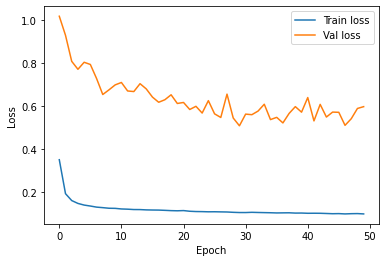

In [ ]:
plot_history(m_history, 'loss') # Types of graphs available: mae, loss, accuracy, precision, recall
# Will need to update the model if we are interested in the recall for the positive cancer prediction

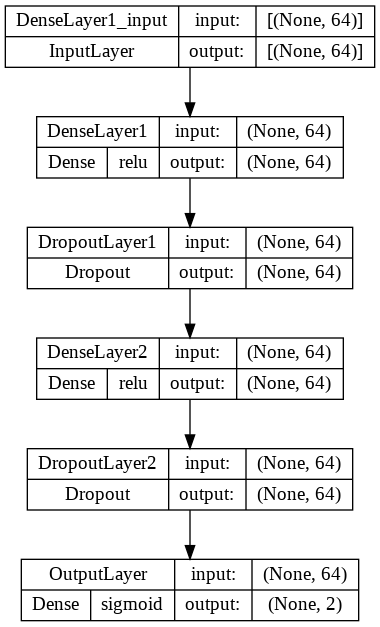

In [ ]:
# Model Architecture:
tf.keras.utils.plot_model(dnn_model, 
                          show_shapes=True, 
                          show_dtype=False,
                          show_layer_activations=True,)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

In [ ]:
# accuracy_score

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

dtc_train_acc = accuracy_score(y_train, dtc.predict(X_train))
dtc_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of Decision Tree is : {dtc_train_acc}")
print(f"Test accuracy of Decision Tree is : {dtc_test_acc}")

Training accuracy of Decision Tree is : 1.0
Test accuracy of Decision Tree is : 0.8824902723735408


In [ ]:
# confusion_matrix and classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3342  282]
 [ 171   60]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3624
           1       0.18      0.26      0.21       231

    accuracy                           0.88      3855
   macro avg       0.56      0.59      0.57      3855
weighted avg       0.90      0.88      0.89      3855



## XGBoost

In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [ ]:
xgb_train_acc = accuracy_score(y_train, xgb.predict(X_train))
xgb_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of XgBoost is : {xgb_train_acc}")
print(f"Test accuracy of XgBoost is : {xgb_test_acc}")

Training accuracy of XgBoost is : 0.9471578366445916
Test accuracy of XgBoost is : 0.9024643320363165


In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3432  192]
 [ 184   47]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3624
           1       0.20      0.20      0.20       231

    accuracy                           0.90      3855
   macro avg       0.57      0.58      0.57      3855
weighted avg       0.90      0.90      0.90      3855

